<a href="https://colab.research.google.com/github/VoKisnaHai1102/DreamDiffusion/blob/main/240563_KrishnaAgrawal_Week2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Extract compressed data archives
!unzip MWData.zip -d extracted_mw_folder
!unzip MuseData.zip -d extracted_muse_folder

# Verify extracted contents
import os
print("Mind Wandering dataset contents:")
print(os.listdir('extracted_mw_folder'))
print("\nMuse dataset contents:")
print(os.listdir('extracted_muse_folder'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d
from sklearn.preprocessing import MinMaxScaler

# Load Muse EEG dataset
muse_brain_data = pd.read_csv("/content/extracted_muse_folder/MU.txt", delimiter="\t")
print("Muse EEG Data Preview:")
print(muse_brain_data.head())

brain_data = pd.read_csv("/content/extracted_mw_folder/MWData/MW.txt", delimiter="\t")
print("\nMind Wandering EEG Data Preview:")
print(brain_data.head())

Archive:  MWData.zip
  inflating: extracted_mw_folder/MWData/MW.txt  
Archive:  MuseData.zip
  inflating: extracted_muse_folder/MU.txt  
Mind Wandering dataset contents:
['MWData']

Muse dataset contents:
['MU.txt']
Muse EEG Data Preview:
   978111  132669  MU   TP9  6  459  \
0  978112  132669  MU   FP1  6  459   
1  978113  132669  MU   FP2  6  459   
2  978114  132669  MU  TP10  6  459   
3  978115  132670  MU   TP9  7  493   
4  978116  132670  MU   FP1  7  493   

  475,474,477,486,486,476,479,483,489,483,482,485,486,483,474,475,484,481,482,478,476,479,487,481,480,479,487,486,471,487,491,488,491,470,460,485,484,482,485,480,487,488,479,471,479,485,484,484,478,478,479,511,524,529,530,529,525,524,533,520,516,520,525,526,521,519,526,527,529,520,520,514,522,523,514,515,517,523,517,515,528,522,530,520,519,504,532,529,528,532,523,531,524,514,522,524,524,519,516,512,519,519,526,517,519,512,523,527,518,530,529,527,524,519,522,520,516,527,525,522,528,524,518,524,530,522,518,514,518,533,521,

In [4]:
neural_channels = brain_data.iloc[:, 1:-1].apply(pd.to_numeric, errors='coerce').values
trigger_column = brain_data.iloc[:, -1].values

In [5]:
def create_bandpass_filter(signal_data, lower_freq, upper_freq, sample_freq, filter_order=4):
    nyquist_freq = 0.5 * sample_freq
    normalized_low = lower_freq / nyquist_freq
    normalized_high = upper_freq / nyquist_freq
    coeffs_b, coeffs_a = butter(filter_order, [normalized_low, normalized_high], btype='band')
    return filtfilt(coeffs_b, coeffs_a, signal_data, axis=0)

fs_hz = 250  # sampling frequency in Hz
clean_signals = create_bandpass_filter(neural_channels, 0.1, 30.0, fs_hz)
print("Initial 10 filtered samples from channel 1:")
print(clean_signals[:10, 0])

Initial 10 filtered samples from channel 1:
[-116.7510111  -116.27367617 -115.79706024 -115.32119954 -114.84614292
 -114.37192559 -113.89855966 -113.4260384  -112.95434694 -112.48347194]


In [6]:
trigger_indices = [idx for idx, trigger_val in enumerate(trigger_column) if trigger_val != 0]
print(f"Total stimulus events found: {len(trigger_indices)}")

baseline_samples = int(0.2 * fs_hz)
response_samples = int(0.8 * fs_hz)

trial_segments = []
for trigger_idx in trigger_indices:
    segment_start = trigger_idx - baseline_samples
    segment_end = trigger_idx + response_samples

    if segment_start >= 0 and segment_end < len(clean_signals):
        trial_segments.append(clean_signals[segment_start:segment_end])

trials_matrix = np.array(trial_segments)
print("Segmented trials dimensions:", trials_matrix.shape)

Total stimulus events found: 67634
Segmented trials dimensions: (67384, 250, 5)


In [7]:
standard_length = int(np.median([trial.shape[0] for trial in trials_matrix]))

def standardize_length(trial_data, desired_length):
    time_original = np.linspace(0, 1, trial_data.shape[0])
    time_resampled = np.linspace(0, 1, desired_length)
    return np.stack([interp1d(time_original, channel_data)(time_resampled)
                     for channel_data in trial_data.T], axis=1)

uniform_trials = np.array([standardize_length(trial, standard_length)
                          for trial in trials_matrix])

In [8]:
def interpolate_gaps(trial_data):
    for ch_idx in range(trial_data.shape[1]):
        channel_signal = trial_data[:, ch_idx]
        if np.isnan(channel_signal).all():
            continue

        time_indices = np.arange(len(channel_signal))
        nan_mask = np.isnan(channel_signal)

        if np.any(nan_mask):
            channel_signal[nan_mask] = np.interp(
                time_indices[nan_mask],
                time_indices[~nan_mask],
                channel_signal[~nan_mask]
            )
        trial_data[:, ch_idx] = channel_signal
    return trial_data

complete_trials = np.array([interpolate_gaps(trial.copy()) for trial in uniform_trials])

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray

Processed data dimensions (trials, timepoints, channels): (67384, 250, 5)


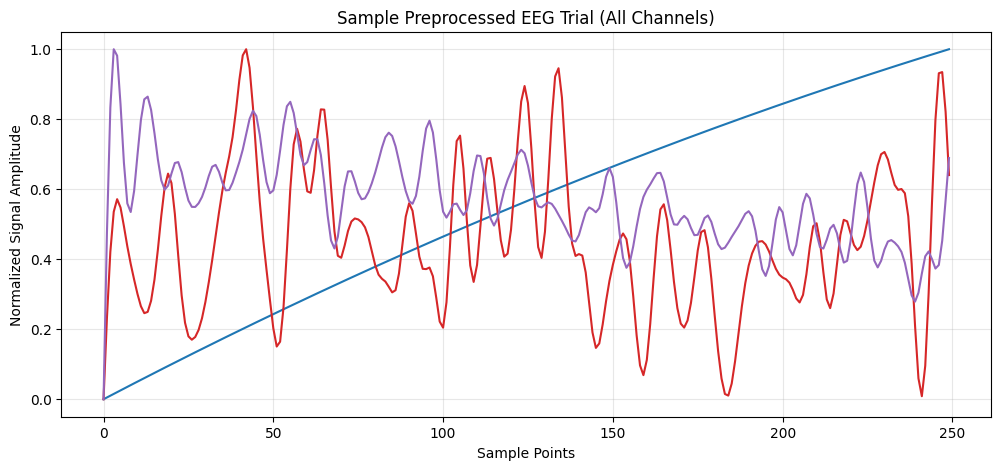

In [9]:
def normalize_trial(trial_data):
    scaler = MinMaxScaler()
    return scaler.fit_transform(trial_data)

scaled_trials = np.array([normalize_trial(trial) for trial in complete_trials])
print("Processed data dimensions (trials, timepoints, channels):", scaled_trials.shape)

plt.figure(figsize=(12, 5))
plt.plot(scaled_trials[0])
plt.title("Sample Preprocessed EEG Trial (All Channels)")
plt.xlabel("Sample Points")
plt.ylabel("Normalized Signal Amplitude")
plt.grid(True, alpha=0.3)
plt.show()

In [10]:
print("Sample normalized values from first trial, first channel:")
print(scaled_trials[0][:10, 0])

Sample normalized values from first trial, first channel:
[0.         0.00507479 0.01014195 0.01520107 0.02025164 0.02529329
 0.03032589 0.0353495  0.0403643  0.04537042]
